# MLB Wins and Loses Model

The following notebook is my Capstone project for the Springboard Data Intensive Course. 

## Project Summary

In Major League Baseball every teams goal is win as many games as they can. General managers and scouts work to build a team to complete the task and coaches work all season to get the best possible performance out of their players. This notebook provides a deeper look into what influences team wins the most. Using machine learning and calculated and non-calculated stats of teams, I will build a model to predict team wins. 

The data I used in this notebook comes from Sean Lahman's database of the history of baseball. The database includes all recorded stats from the beginning of recorded baseball in 1871, to 2015. For this project, only the 'team' table will be used.

The non-calculated stats in this project are stats recorded based on events. This includes 'hits', 'doubles', 'triples', 'home runs', 'strikeouts', 'walks'. The calculated stats are certain stats that provide a more detailed analysis on a players performance. They are claculated using the non-calculated stats like mentioned before. The calcualted stats used in this project are 'batting average', 'slugging percentage', 'on-base percentage', 'on-base plus slugging', 'weighted on-base average', and 'strikeout percentage'.

In [149]:
%matplotlib inline

In [239]:
from pylab import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from mpl_toolkits.mplot3d import Axes3D
pd.options.display.float_format = "{:.4f}".format # two decimal places

## Data

In [151]:
#Datasets
team_reg_bat = pd.DataFrame.from_csv('data/team.csv', index_col = None, encoding = ('utf-8'))

In [152]:
team_reg_bat.columns

Index(['year', 'league_id', 'team_id', 'franchise_id', 'div_id', 'rank', 'g',
       'ghome', 'w', 'l', 'div_win', 'wc_win', 'lg_win', 'ws_win', 'r', 'ab',
       'h', 'double', 'triple', 'hr', 'bb', 'so', 'sb', 'cs', 'hbp', 'sf',
       'ra', 'er', 'era', 'cg', 'sho', 'sv', 'ipouts', 'ha', 'hra', 'bba',
       'soa', 'e', 'dp', 'fp', 'name', 'park', 'attendance', 'bpf', 'ppf',
       'team_id_br', 'team_id_lahman45', 'team_id_retro'],
      dtype='object')

## Cleaning Data

In baseball, performance cultures have changed over thee years. In the early years of baseball defense and pitching dominated the league. In the mid 90's to mid 2000's, the steroid era, was dominated by offense. It is important to use data from the same era so the data is comparable to each other. The data used will be of the modern age of baseball, from 2005 to present day.

In [153]:
team_rb = team_reg_bat.loc[team_reg_bat['year'] >= 2005, :]

In [154]:
####### Team Column Labeling #######

#Team Regular Season Batting
team_reg_bat = team_reg_bat.fillna(0)
tr_ab = team_rb['ab']
tr_bb = team_rb['bb']
tr_hbp = team_rb['hbp']
tr_sf = team_rb['sf']
tr_h = team_rb['h']
tr_dou = team_rb['double']
tr_tri = team_rb['triple']
tr_hr = team_rb['hr']
tr_sin = tr_h - (tr_dou + tr_tri + tr_hr)
trb_teamid = team_rb['team_id']
tr_bso = team_rb['so'].dropna()
tr_sb = team_rb['sb']

### Calculated Stats

- Batting Average: the average performance of a batter, expressed as a ratio of a batter's safe hits per official times at bat.
- Slugging Percentage: represents the total number of bases a player records per at-bat.
- On-Base Percentage: refers to how frequently a batter reaches base per plate appearance.
- On-Base Plu Slugging: meant to combine how well a hitter can reach base, with how well he can hit for average and for power.
- Weighted On-Base Average: a version of on-base percentage that accounts for how a player reached base -- instead of simply considering whether a player reached base.
- Strikeout Percentage: represents the frequency with which a pitcher strikes out hitters.

In [155]:
####### Team Batting Statistic Calculations #######

#Batting Average
team_rb['bat_avg'] = tr_h/tr_ab
tr_avg = team_rb['bat_avg']
#Slugging Percentage
team_rb['slg'] = (tr_sin + 2*tr_dou + 3*tr_tri + 4*tr_hr)/tr_ab
tr_slg = team_rb['slg']
#On Base Percentage
team_rb['obp'] = (tr_h + tr_bb + tr_hbp)/(tr_ab + tr_bb + tr_hbp + tr_sf)
tr_obp = team_rb['obp']
#On Base PLus Slugging
team_rb['ops'] = tr_slg + tr_obp
tr_ops = team_rb['ops']
#Weighted On Base Average
team_rb['woba'] = (.69*tr_bb + .72*tr_hbp + .89*tr_sin + 1.27*tr_dou + 1.62*tr_tri + 2.10*tr_hr)/(tr_ab + tr_bb + tr_sf + tr_hbp)
tr_woba = team_rb['woba']
#Strikeout Percentage
team_rb['kperc'] = tr_bso / (tr_ab + tr_bb + tr_hbp + tr_sf)
tr_kperc = team_rb['kperc']

## Distribution of Data

In [156]:
fig = plt.figure()

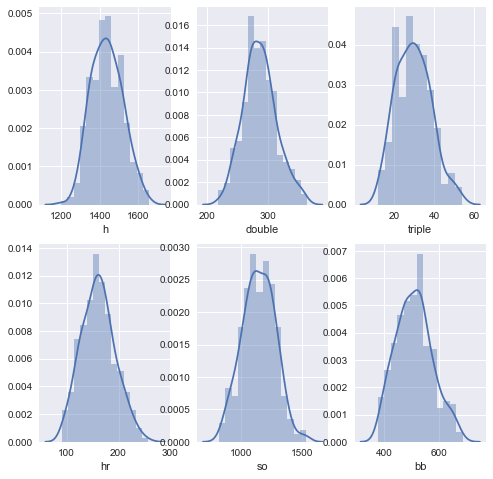

In [157]:
####### DISTRIBUTION PLOTS FOR TEAM OFFENSIVE STATS #######

fig, ax = plt.subplots(2,3,figsize=(8,8))

sns.distplot(team_rb_h.h, ax=ax[0,0])
sns.distplot(team_rb_d.double, ax=ax[0,1])
sns.distplot(team_rb_t.triple, ax=ax[0,2])
sns.distplot(team_rb_hr.hr, ax=ax[1,0])
sns.distplot(team_rb_so.so, ax=ax[1,1])
sns.distplot(team_rb_bb.bb, ax=ax[1,2])
None

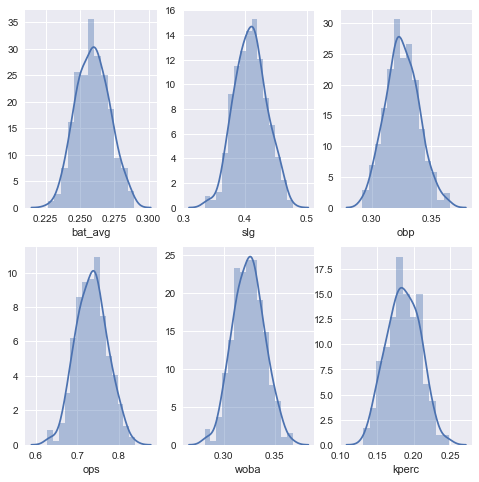

In [158]:
####### DISTRIBUTION PLOTS FOR TEAM CALCULATED OFFENSIVE STATS #######

fig, ax = plt.subplots(2,3,figsize=(8,8))

sns.distplot(team_rb_avg.bat_avg, ax=ax[0,0])
sns.distplot(team_rb_slg.slg, ax=ax[0,1])
sns.distplot(team_rb_obp.obp, ax=ax[0,2])
sns.distplot(team_rb_ops.ops, ax=ax[1,0])
sns.distplot(team_rb_woba.woba, ax=ax[1,1])
sns.distplot(team_rb_kperc.kperc, ax=ax[1,2])
None

It can be seen that all stats used in this project are normally ditributed.

## Non-Calculated Stat  vs. Wins Regression

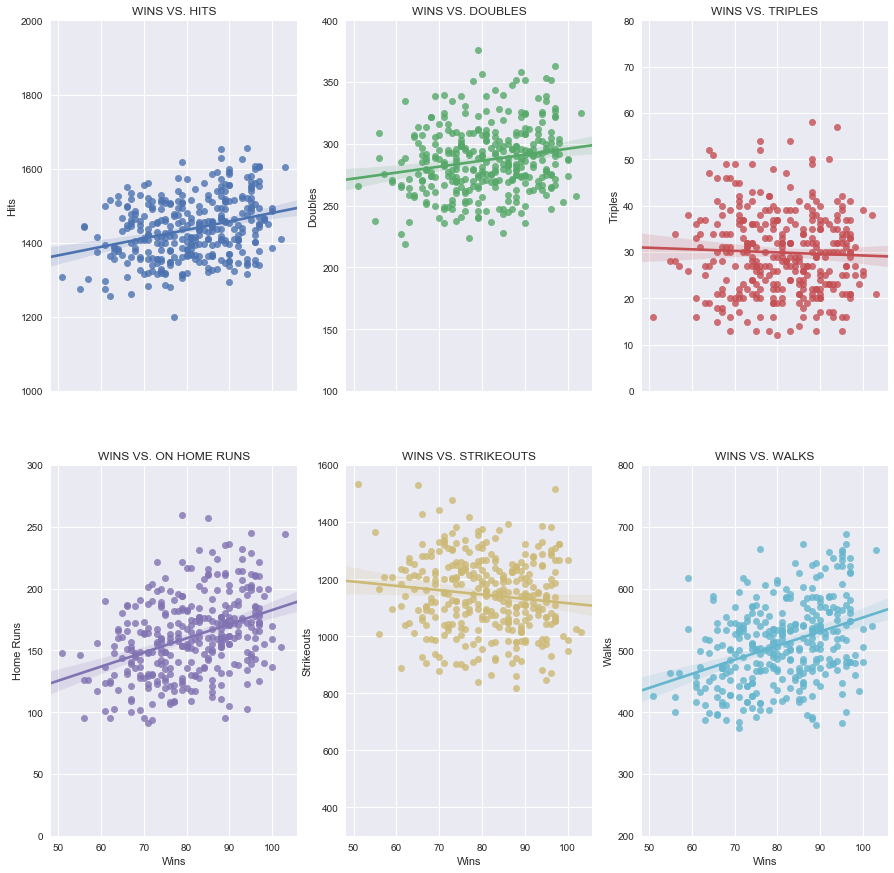

In [159]:
####### REGULAR SEASON STATS TO WINS #######

fig, ax = plt.subplots(2,3,figsize=(15,15), sharex = True)

# Hits Scatter
sns.regplot(x='w', y='h', data=team_rb, ax=ax[0,0])
ax[0,0].set_title('WINS VS. HITS')
ax[0,0].set_ylabel('Hits')
ax[0,0].set_xlabel('')
ax[0,0].set_ylim([1000,2000])
h_slope, h_intercept, h_r_value, h_p_value, h_slope_std_error = scipy.stats.linregress(team_rb.w, team_rb.h)

# Doubles Scatter
sns.regplot(x='w', y='double', data=team_rb, ax=ax[0,1])
ax[0,1].set_title('WINS VS. DOUBLES')
ax[0,1].set_ylabel('Doubles')
ax[0,1].set_xlabel('')
ax[0,1].set_ylim([100,400])
d_slope, d_intercept, d_r_value, d_p_value, d_slope_std_error = scipy.stats.linregress(team_rb.w, team_rb.double)

# Triples Scatter
sns.regplot(x='w', y='triple', data=team_rb, ax=ax[0,2])
ax[0,2].set_title('WINS VS. TRIPLES')
ax[0,2].set_ylabel('Triples')
ax[0,2].set_xlabel('')
ax[0,2].set_ylim([0,80])
t_slope, t_intercept, t_r_value, t_p_value, t_slope_std_error = scipy.stats.linregress(team_rb.w, team_rb.triple)

# Home Runs Scatter
sns.regplot(x='w', y='hr', data=team_rb, ax=ax[1,0])
ax[1,0].set_title('WINS VS. ON HOME RUNS')
ax[1,0].set_ylabel('Home Runs')
ax[1,0].set_xlabel('Wins')
ax[1,0].set_ylim([0,300])
hr_slope, hr_intercept, hr_r_value, hr_p_value, hr_slope_std_error = scipy.stats.linregress(team_rb.w, team_rb.hr)

# Strikeouts Scatter
sns.regplot(x='w', y='so', data=team_rb, ax=ax[1,1])
ax[1,1].set_title('WINS VS. STRIKEOUTS')
ax[1,1].set_ylabel('Strikeouts')
ax[1,1].set_xlabel('Wins')
ax[1,1].set_ylim([300,1600])
so_slope, so_intercept, so_r_value, so_p_value, so_slope_std_error = scipy.stats.linregress(team_rb.w, team_rb.so)

# Walks Scatter
sns.regplot(x='w', y='bb', data=team_rb, ax=ax[1,2])
ax[1,2].set_title('WINS VS. WALKS')
ax[1,2].set_ylabel('Walks')
ax[1,2].set_xlabel('Wins')
ax[1,2].set_ylim([200,800])
bb_slope, bb_intercept, bb_r_value, bb_p_value, bb_slope_std_error = scipy.stats.linregress(team_rb.w, team_rb.bb)

In [240]:
reg_ncalc_table = [['Slope', h_slope, d_slope, t_slope, hr_slope, so_slope, bb_slope],
                   ['Intercept', h_intercept, d_intercept, t_intercept, hr_intercept, so_intercept, bb_intercept],
                   ['R-Squared Value', h_r_value**2, d_r_value**2, t_r_value**2, hr_r_value**2, so_r_value**2, bb_r_value**2],
                   ['P Value', h_p_value, d_p_value, t_p_value, hr_p_value, so_p_value, bb_p_value],
                   ['Slope Standard Deviation Error', h_slope_std_error, d_slope_std_error, t_slope_std_error, hr_slope_std_error, so_slope_std_error, bb_slope_std_error]]
reg_ncalc_table = pd.DataFrame(reg_ncalc_table).set_index(keys = 0)
reg_ncalc_table.columns = ['Hits', 'Doubles', 'Triples', 'Home Runs', 'Strikeouts', 'Walks']
reg_ncalc_table.index.name = ''
reg_ncalc_table

,Hits,Doubles,Triples,Home Runs,Strikeouts,Walks
,,,,,,
Slope,2.2918,0.4840,-0.0335,1.1454,-1.5169,2.2847
Intercept,1251.4001,247.7453,32.6019,68.2493,1267.6469,325.0453
R-Squared Value,0.0905,0.0359,0.0016,0.1424,0.0147,0.1340
P Value,0.0000,0.0005,0.4701,0.0000,0.0275,0.0000
Slope Standard Deviation Error,0.4011,0.1386,0.0463,0.1552,0.6853,0.3208


Based on the plots and table above, multiple conclussions can be made. The first thing that jumps out is the wins and triples relationship. There appears to be no correlation at all. What is really interesting is the regression line slope appears to be negative. Triples are a great thing when they occur in a game but aren't always a skill only based stat. There are multiple reasons a triple can happen that a hitter doesn't intend to do. For example, if the ball takes a funny bounce of the wall and gets passed the outfielder, that wasn't the intention of the hitter for it to occur but allowed him to reach third safely. For this reason it can be said that the number of triples a team has will not be needed in the model. A slight linear relationship can be seen from doubles and strikeouts, but not enough to make a significant positive impact on the model.

Looking at the other stats, the stats that stick out the most for having a linear relationship with wins is hits, home runs, and walks. This makes sense becuase the ultimate goal for hitter is to get on base or drive in runs. Home runs are important because it is an automatic run that is scored. Also, with the range of runs that can be scored by a home run being one to four, having men on base can impact the number of runs that can be scored. Walks are a free pass for a hitter and automatically makes them a potential run to be scored and hits mean not only is a runner on base, but depending on the type of hit the runner could be in scoring position immediatley, or score runs from the hit itself.

## Calcualted Stat vs. Wins Regression

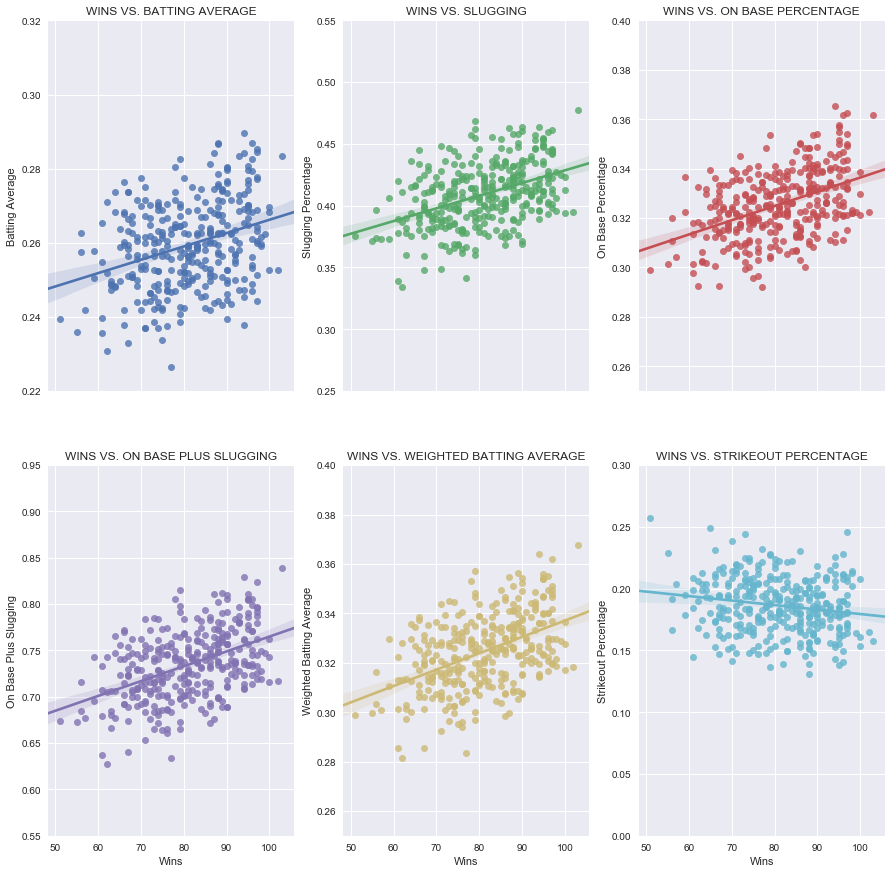

In [232]:
####### REGULAR SEASON CALCUALTED STATS TO WINS #######

fig, ax = plt.subplots(2,3,figsize=(15,15), sharex = True)

sns.regplot(x='w', y='bat_avg', data=team_rb, ax=ax[0,0])
ax[0,0].set_title('WINS VS. BATTING AVERAGE')
ax[0,0].set_ylabel('Batting Average')
ax[0,0].set_xlabel('')
ax[0,0].set_ylim([.22,.32])
avg_slope, avg_intercept, avg_r_value, avg_p_value, avg_slope_std_error = scipy.stats.linregress(team_rb.w, team_rb.bat_avg)

sns.regplot(x='w', y='slg', data=team_rb, ax=ax[0,1])
ax[0,1].set_title('WINS VS. SLUGGING')
ax[0,1].set_ylabel('Slugging Percentage')
ax[0,1].set_xlabel('')
ax[0,1].set_ylim([.25,.55])
slg_slope, slg_intercept, slg_r_value, slg_p_value, slg_slope_std_error = scipy.stats.linregress(team_rb.w, team_rb.slg)

sns.regplot(x='w', y='obp', data=team_rb, ax=ax[0,2])
ax[0,2].set_title('WINS VS. ON BASE PERCENTAGE')
ax[0,2].set_ylabel('On Base Percentage')
ax[0,2].set_xlabel('')
ax[0,2].set_ylim([.25,.4])
obp_slope, obp_intercept, obp_r_value, obp_p_value, obp_slope_std_error = scipy.stats.linregress(team_rb.w, team_rb.obp)

sns.regplot(x='w', y='ops', data=team_rb, ax=ax[1,0])
ax[1,0].set_title('WINS VS. ON BASE PLUS SLUGGING')
ax[1,0].set_ylabel('On Base Plus Slugging')
ax[1,0].set_xlabel('Wins')
ax[1,0].set_ylim([.55,.95])
ops_slope, ops_intercept, ops_r_value, ops_p_value, ops_slope_std_error = scipy.stats.linregress(team_rb.w, team_rb.ops)

sns.regplot(x='w', y='woba', data=team_rb, ax=ax[1,1])
ax[1,1].set_title('WINS VS. WEIGHTED BATTING AVERAGE')
ax[1,1].set_ylabel('Weighted Batting Average')
ax[1,1].set_xlabel('Wins')
ax[1,1].set_ylim([.25,.4])
woba_slope, woba_intercept, woba_r_value, woba_p_value, woba_slope_std_error = scipy.stats.linregress(team_rb.w, team_rb.woba)

sns.regplot(x='w', y='kperc', data=team_rb, ax=ax[1,2])
ax[1,2].set_title('WINS VS. STRIKEOUT PERCENTAGE')
ax[1,2].set_ylabel('Strikeout Percentage')
ax[1,2].set_xlabel('Wins')
ax[1,2].set_ylim([0,.3])
kperc_slope, kperc_intercept, kperc_r_value, kperc_p_value, kperc_slope_std_error = scipy.stats.linregress(team_rb.w, team_rb.kperc)
None

In [371]:
reg_calc_table = [['Slope', avg_slope, slg_slope, obp_slope, ops_slope, woba_slope, kperc_slope],
                   ['Intercept', avg_intercept, slg_intercept, obp_intercept, ops_intercept, woba_intercept, kperc_intercept],
                   ['R-Squared Value', avg_r_value**2, slg_r_value**2, obp_r_value**2, ops_r_value**2, woba_r_value**2, kperc_r_value**2],
                   ['P Value', avg_p_value, slg_p_value, obp_p_value, ops_p_value, woba_p_value, kperc_p_value]]
reg_calc_table = pd.DataFrame(reg_calc_table).set_index(keys = 0)
reg_calc_table.columns = ['Batting Average', 'Slugging Percentage', 'On-Base Percentage', 'On-Base Plus Slugging', 'Weighted On-Base Average', 'Strikeout Percentage']
reg_calc_table.index.name = ''
reg_calc_table

,Batting Average,Slugging Percentage,On-Base Percentage,On-Base Plus Slugging,Weighted On-Base Average,Strikeout Percentage
,,,,,,
Slope,0.0004,0.0010,0.0006,0.0016,0.0007,-0.0004
Intercept,0.2302,0.3260,0.2788,0.6048,0.2709,0.2159
R-Squared Value,0.1039,0.1821,0.1980,0.2103,0.2170,0.0290
P Value,0.0000,0.0000,0.0000,0.0000,0.0000,0.0019


The calculated stats show better linear regression results than the non-calculated stats. When observing the plots, it seems that batting average and strikeout percentage are the stats that have the weakest relationship with wins. When building the model these features should be left out. 

The two stats that standout as having the best linear relationship are on-base plus slugging and weighted on-base average. Both stats are more detailed stats that account for how many times a batter reached base as well as how many bases he reaches with each at-bat.

## Compare Linear Regression Models

First, I'll run a Linear Regression model over all features and one using the features I predict to produce a better model. The results will show if my predictions were correct or not.

In [306]:
ncalc = team_rb[['h', 'double', 'triple', 'hr', 'so', 'bb']]
calc = team_rb[['bat_avg', 'slg', 'obp', 'ops', 'woba', 'kperc']]
wins = team_rb['w']

In [307]:
# Splitting training and testing data sets for non-calcualted stats
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lm = LinearRegression()

In [372]:
# Linear Regression model
def LR(X, y) :
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state = 5) 
    lm.fit(X_train, Y_train)
    pred = lm.predict(X_test)
    rmse = np.sqrt(mean_squared_error(Y_test, pred))
    return rmse

In [375]:
h = pd.DataFrame(ncalc.h)
d = pd.DataFrame(ncalc.double)
t = pd.DataFrame(ncalc.triple)
hr = pd.DataFrame(ncalc.hr)
so = pd.DataFrame(ncalc.so)
bb = pd.DataFrame(ncalc.bb)
ncalc_pred_feat = pd.DataFrame(list(zip(ncalc.h, ncalc.hr, ncalc.bb, ncalc.so, ncalc.double)))

all_feat_ncalc_LR = LR(ncalc, wins)
h_LR = LR(h, wins)
d_LR = LR(d, wins)
t_LR = LR(t, wins)
hr_LR = LR(hr, wins)
so_LR = LR(so, wins)
bb_LR = LR(bb, wins)
pred_feat_ncalc_LR = LR(pred_feat, wins)

feat_names = ['Hits',
             'Doubles',
             'Triples',
             'Home Runs',
             'Strikeouts',
             'Walks',
             'Predicted Features',
             'All Features']
feat_rmse = [h_LR,
            d_LR,
            t_LR,
            hr_LR,
            so_LR,
            bb_LR,
            pred_feat_ncalc_LR,
            all_feat_ncalc_LR]
table = pd.DataFrame(list(zip(feat_names, feat_rmse)))
table.columns = ['Feature Names', 'Root Mean Squared Error']
table.set_index('Feature Names', inplace = True)
table

,Root Mean Squared Error
Feature Names,
Hits,10.8372
Doubles,10.8523
Triples,11.0685
Home Runs,9.9539
Strikeouts,11.0574
Walks,9.9873
Predicted Features,9.4868
All Features,9.4894


According to root mean squared errors of the non-calcualted errors, all the features except for the number of triples a team hits a year contributes to the best possible linear regression model.

In [376]:
avg = pd.DataFrame(calc.bat_avg)
slg = pd.DataFrame(calc.slg)
obp = pd.DataFrame(calc.obp)
ops = pd.DataFrame(calc.ops)
woba = pd.DataFrame(calc.woba)
kperc = pd.DataFrame(calc.kperc)
calc_pred_feat = pd.DataFrame(list(zip(calc.ops, calc.slg, calc.obp, calc.bat_avg, calc.woba)))

all_feat_calc_LR = LR(calc, wins)
avg_LR = LR(avg, wins)
slg_LR = LR(slg, wins)
obp_LR = LR(obp, wins)
ops_LR = LR(ops, wins)
woba_LR = LR(woba, wins)
kperc_LR = LR(kperc, wins)
pred_feat_calc_LR = LR(pred_feat, wins)

feat_names = ['Batting Average',
             'Slugging Percentage',
             'On-Base Percentage',
             'On-Base Plus Slugging',
             'Weighted On-Base Average',
             'Strikeout Percentage',
             'Predicted Features',
             'All Features']
feat_rmse = [avg_LR,
            slg_LR,
            obp_LR,
            ops_LR,
            woba_LR,
            kperc_LR,
            pred_feat_calc_LR,
            all_feat_calc_LR]
table = pd.DataFrame(list(zip(feat_names, feat_rmse)))
table.columns = ['Feature Names', 'Root Mean Squared Error']
table.set_index('Feature Names', inplace = True)
table

,Root Mean Squared Error
Feature Names,
Batting Average,10.8127
Slugging Percentage,9.9070
On-Base Percentage,9.9584
On-Base Plus Slugging,9.7797
Weighted On-Base Average,9.7337
Strikeout Percentage,10.9832
Predicted Features,9.4868
All Features,9.5457


From the root mean squares of the calculated stats the best possible linear regression model includes all stats except strikeout percentage. However no combination of calculated stats produce a better model than what the non-calculated stats produced.

## Machine Learning Models

Some machine learning techniques are better for regression and classifying. This project involves a regression analysis that will best be modeled by Linear Regression, SVM, and Decision Tree Regression models.

### Support Vector Machine

In [474]:
from sklearn import svm

C_vals = [.001, .01, .1, 1, 10, 100]
gamma_vals = [.001, .01, .1, 1, 10, 100]

svm_best_score = 0
svm_best_param = {'C': None, 'gamma': None}


for C in C_vals:
    for gamma in gamma_vals:
        clf = svm.SVR(C=C, gamma=gamma) 
        clf.fit(ncalc_pred_feat, wins)
        score = clf.score(ncalc_pred_feat, wins)
        
        if score > svm_best_score:
            svm_best_param['C'] = C
            svm_best_param['gamma'] = gamma
                
print("Best Accuracy Score: %0.2f%%" %(svm_best_score))
print("Best C Value:".format(svm_best_param['C']))
print("Best Gamma Value:".format(svm_best_param['gamma']))
  

Best Accuracy Score: 0.00%
Best C Value:
Best Gamma Value:


In [475]:
clf = svm.SVR(C=.001, gamma=1.5) 
clf.fit(ncalc_pred_feat, wins)
score = clf.score(ncalc_pred_feat, wins)
score

5.2716679719955195e-05

In [476]:
test_season = pd.DataFrame.from_csv('data/2016season.csv', index_col = None)
test = test_season[['H', '2B', 'HR', 'SO', 'BB']]
clf.predict(test)

array([ 81.1005,  81.1005,  81.1005,  81.1005,  81.1005,  81.1005,
        81.1005,  81.1005,  81.1005,  81.1005,  81.1005,  81.1005,
        81.1005,  81.1005,  81.1005,  81.1005,  81.1005,  81.1005,
        81.1005,  81.1005,  81.1005,  81.1005,  81.1005,  81.1005,
        81.1005,  81.1005,  81.1005,  81.1005,  81.1005,  81.1005,
        81.1005,  81.1005])

### Decision Tree

In [471]:
from sklearn import tree
from sklearn.model_selection import cross_val_score

def DT(X, y) :
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state = 5)
    clf = tree.DecisionTreeRegressor()
    clf = clf.fit(X_train, Y_train)
    pred = clf.predict(X_test)
    train_score = clf.score(X_train, Y_train)
    test_score = clf.score(X_test, Y_test)
    rmse = np.sqrt(mean_squared_error(Y_test, pred))
    print("Training Accuracy Score: ", train_score)
    print("Testing Accuracy Score: ", test_score)

In [469]:
DT(ncalc_pred_feat, wins)

Training Accuracy Score:  1.0
Testing Accuracy Score:  -0.32679981774


In [470]:
DT(calc_pred_feat, wins)

Training Accuracy Score:  1.0
Testing Accuracy Score:  -0.629951397327


# STOP

## Support Vector Machine (SVM): Non-Calculated vs. Wins

In [207]:
from sklearn.svm import SVC

In [208]:
clf = SVC(C=1, gamma=10, kernel='rbf')

In [209]:
clf.fit(df_new, wins)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=10, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [210]:
pred = clf.predict(df_new)
pred[0:5]

array([77, 90, 74, 95, 99], dtype=int64)

In [211]:
clf.score(df_new, wins)

1.0

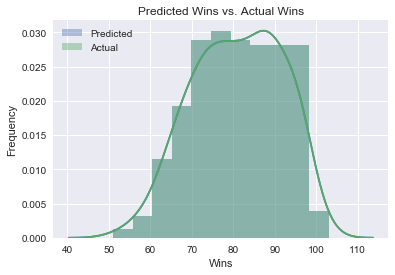

In [212]:
sns.distplot(pred, label='Predicted')
sns.distplot(wins, label='Actual')
plt.title("Predicted Wins vs. Actual Wins")
plt.xlabel("Wins")
plt.ylabel("Frequency")
plt.legend()

In [213]:
test_season = pd.DataFrame.from_csv('data/2016season.csv', index_col = None)
test_season = test_season[['H', 'HR', 'BB']]
print(df_new.shape)
print(test_season.shape)

(330, 3)
(32, 3)


In [214]:
clf.predict(test_season)

array([88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88,
       88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88], dtype=int64)

In [215]:
clf = SVC(C=1, gamma=1, kernel='rbf')

In [216]:
clf.fit(df_new1, wins)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [217]:
pred1 = clf.predict(df_new1)
pred1[0:5]

array([88, 88, 88, 88, 88], dtype=int64)

In [218]:
clf.score(df_new1, wins)

0.048484848484848485

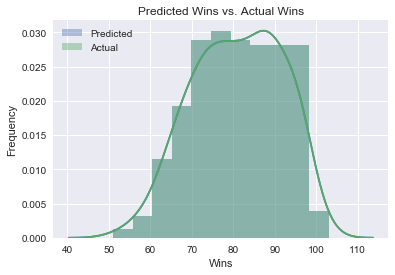

In [219]:
sns.distplot(pred, label='Predicted')
sns.distplot(wins, label='Actual')
plt.title("Predicted Wins vs. Actual Wins")
plt.xlabel("Wins")
plt.ylabel("Frequency")
plt.legend()